# Imports

In [1]:
# Importation des bibliothèques nécessaires
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm

# Importation des composants de TensorFlow Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,Layer, Flatten, InputLayer, 
    BatchNormalization, Input, Embedding, Permute, Dropout, RandomFlip, RandomRotation, LayerNormalization, 
    MultiHeadAttention, RandomContrast, Rescaling, Resizing, Reshape
)
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.regularizers import L2, L1

# Importation des fonctions de TensorFlow pour le traitement des données
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

# Importation des fonctions spécifiques de sklearn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix, roc_curve


In [13]:
!pip install wandb

In [14]:


import wandb
from wandb.keras import WandbCallback

In [15]:


!wandb login

wandb: Currently logged in as: wissal-fnaich (wissal-fnaich-ai). Use `wandb login --relogin` to force relogin


In [16]:


wandb.init(project="Humen_Detection", entity="wissal-fnaich-ai")

wandb: Currently logged in as: wissal-fnaich (wissal-fnaich-ai). Use `wandb login --relogin` to force relogin


In [4]:
CONFIGURATION = { "BATCH_SIZE": 32, "IM_SIZE": 256, "LEARNING_RATE": 1e-3, "N_EPOCHS": 5, "DROPOUT_RATE": 0.0, 
                 "REGULARIZATION_RATE": 0.0, "N_FILTERS": 6, "KERNEL_SIZE": 3, "N_STRIDES": 1, "POOL_SIZE": 2, "N_DENSE_1": 1024,
                 "N_DENSE_2": 128, "NUM_CLASSES": 3, "PATCH_SIZE": 16, "PROJ_DIM": 768, "CLASS_NAMES": ["angry", "happy", "sad"], }

In [17]:

wandb.config = CONFIGURATION

# Dataset Loading

In [5]:
train_directory = "Emotions Dataset/Emotions Dataset/train"

In [6]:
val_directory = "Emotions Dataset/Emotions Dataset/test"

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory( train_directory, labels='inferred', label_mode='categorical', 
                                                            class_names=CONFIGURATION["CLASS_NAMES"],
                                                            color_mode='rgb', batch_size=CONFIGURATION["BATCH_SIZE"],
                                                            image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]), shuffle=True, seed=99, )

Found 6799 files belonging to 3 classes.


In [8]:

val_dataset = tf.keras.utils.image_dataset_from_directory( val_directory, labels='inferred', label_mode='categorical', 
                                                          class_names=CONFIGURATION["CLASS_NAMES"],
                                                            color_mode='rgb', batch_size=CONFIGURATION["BATCH_SIZE"],
                                                            image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]), shuffle=True, seed=99, )

Found 2278 files belonging to 3 classes.


# Dataset Visualization

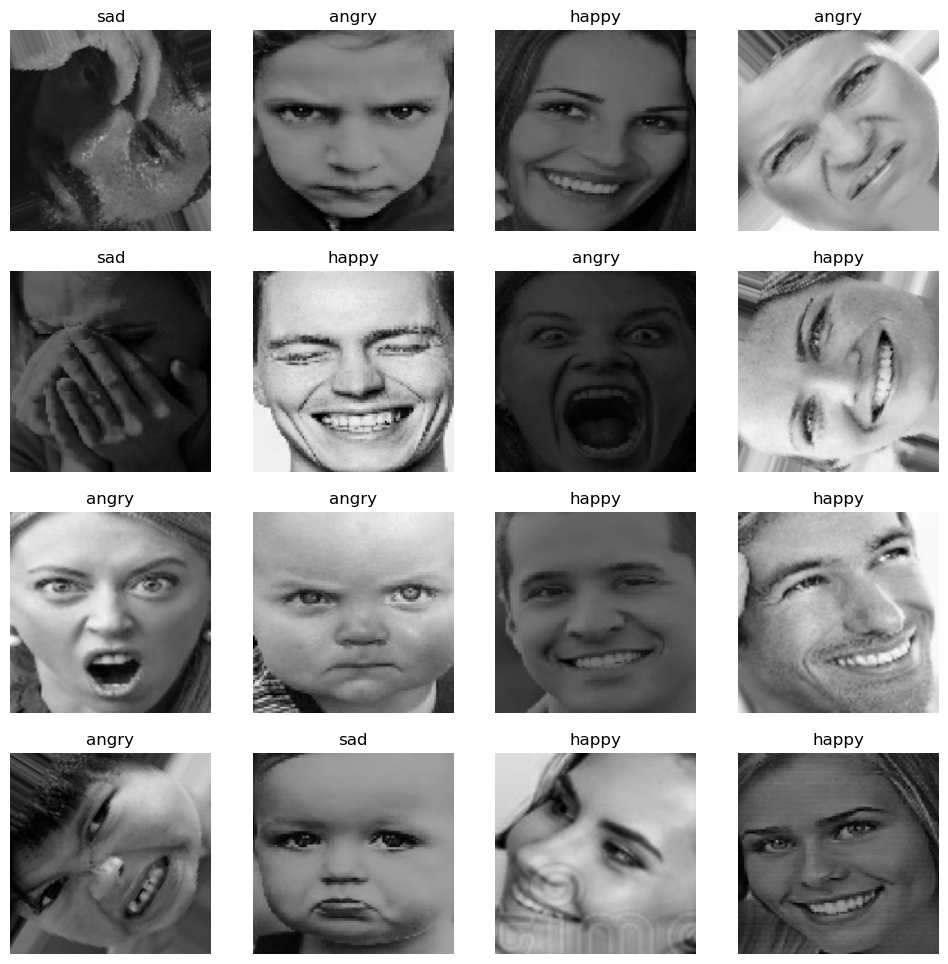

In [7]:
plt.figure(figsize = (12,12)) 
for images, labels in train_dataset.take(1): 
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.) 
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()]) 
        plt.axis("off")

# Data Augmentation

In [9]:

### tf.keras.layer augment 
augment_layers = tf.keras.Sequential([ 
    RandomRotation(factor = (-0.025, 0.025)), RandomFlip(mode='horizontal',), RandomContrast(factor=0.1), ])
def augment_layer(image, label): return augment_layers(image, training = True), label

# Cutmix Augmentation

In [9]:

def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32) 
    r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32) 
    r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"]) 
    r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"]) 
    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"]) 
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])
    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w = 1
        r_h = y_b_r - r_y 
        if(r_h == 0):
            r_h = 1 
    return r_y, r_x, r_h, r_w

In [10]:

def cutmix(train_dataset_1, train_dataset_2): 
    (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2 
    lamda = tfp.distributions.Beta(2,2) 
    lamda = lamda.sample(1)[0] 
    r_y, r_x, r_h, r_w = box(lamda) 
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w) 
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])
    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w) 
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]) 
    image = image_1 - pad_1 + pad_2 
    lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32) 
    return image, label

In [11]:

#train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE) 
#train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE) 
#mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [12]:

 #training_dataset = (  mixed_dataset .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE) 
                     #.prefetch(tf.data.AUTOTUNE)
                #    )

# Data Preparation

In [10]:

training_dataset = ( train_dataset .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                   .prefetch(tf.data.AUTOTUNE) )

In [11]:

validation_dataset = ( val_dataset .prefetch(tf.data.AUTOTUNE) )

In [12]:

resize_rescale_layers = tf.keras.Sequential([ Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
                                             Rescaling(1./255), ])

# Modeling

# Lenet

In [16]:

lenet_model = tf.keras.Sequential( [ InputLayer(input_shape = (None, None, 3), ), resize_rescale_layers, 
                                    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"],
                                           strides = CONFIGURATION["N_STRIDES"] , padding='valid', activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])), 
                                    BatchNormalization(), MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
                                    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ), Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4,
                                                                                           kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"],
                                                                                           padding='valid', activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
                                    BatchNormalization(), MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2), Flatten(), Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])), BatchNormalization(), Dropout(rate = CONFIGURATION["DROPOUT_RATE"]), Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])), BatchNormalization(),
                                    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"), ]) 
lenet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)    

# Complete Network


# ResNet34

# CustomConv2D

In [22]:

class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding='valid', **kwargs):
        super(CustomConv2D, self).__init__(name='custom_conv2d', **kwargs)
        self.conv = Conv2D(
            filters=n_filters,
            kernel_size=kernel_size,
            activation='relu',
            strides=n_strides,
            padding=padding
        )
        self.batch_norm = BatchNormalization()

    def call(self, x, training=True):
        x = self.conv(x)
        return self.batch_norm(x, training=training)

# Residual Block

In [23]:

class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides=1, **kwargs):
        super(ResidualBlock, self).__init__(name='res_block', **kwargs)
        self.dotted = (n_strides != 1)
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding="same")
        self.activation = Activation('relu')
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

    def call(self, inputs, training=False):
        x = self.custom_conv_1(inputs, training=training)
        x = self.custom_conv_2(x, training=training)
        if self.dotted:
            shortcut = self.custom_conv_3(inputs, training=training)
        else:
            shortcut = inputs
        x = Add()([x, shortcut])
        return self.activation(x)

In [24]:
class ResNet34(Model):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__(name='resnet_34')
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.max_pool = MaxPooling2D(3, 2)
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        self.global_pool = GlobalAveragePooling2D()
        self.fc_3 = Dense(num_classes, activation='softmax')

    def call(self, x, training=True):
        x = self.conv_1(x)
        x = self.max_pool(x)
        x = self.conv_2_1(x, training=training)
        x = self.conv_2_2(x, training=training)
        x = self.conv_2_3(x, training=training)
        x = self.conv_3_1(x, training=training)
        x = self.conv_3_2(x, training=training)
        x = self.conv_3_3(x, training=training)
        x = self.conv_3_4(x, training=training)
        x = self.conv_4_1(x, training=training)
        x = self.conv_4_2(x, training=training)
        x = self.conv_4_3(x, training=training)
        x = self.conv_4_4(x, training=training)
        x = self.conv_4_5(x, training=training)
        x = self.conv_4_6(x, training=training)
        x = self.conv_5_1(x, training=training)
        x = self.conv_5_2(x, training=training)
        x = self.conv_5_3(x, training=training)
        x = self.global_pool(x)
        return self.fc_3(x)

In [26]:

resnet_34 = ResNet34(CONFIGURATION["NUM_CLASSES"]) 
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()


Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  2

In [27]:

checkpoint_callback = ModelCheckpoint( 'best_weights', 
                                      monitor='val_accuracy', mode = 'max', verbose=1, save_best_only=True, )

# Transfer Learning with EfficientNet

In [28]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4( include_top = False, weights='imagenet', input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3), )

71686520/71686520 [==============================] - 131s 2us/step


In [29]:
backbone.trainable = False

In [30]:
pretrained_model = tf.keras.Sequential([ Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)), backbone, GlobalAveragePooling2D(), Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"), BatchNormalization(), Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"), Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"), ])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_36 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                      

# Transfer Learning with MobileNetV2

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2( include_top = False,
                                                          weights='imagenet', input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3), )

In [ ]:

backbone.trainable = False

In [ ]:

pretrained_model = tf.keras.Sequential([ Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)), backbone, GlobalAveragePooling2D(), Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"), BatchNormalization(), Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"), Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"), ]) 
pretrained_model.summary()

# FineTuning EficientNet

In [31]:
backbone.trainable = True

In [32]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)) 
x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x) 
x = BatchNormalization()(x) 
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x) 
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)
finetuned_model = Model(input, output)

In [33]:
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_37 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                             

# Training

In [22]:

loss_function = CategoricalCrossentropy() 

In [23]:

metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]



In [ ]:

pretrained_model.compile( optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), 
                         loss = loss_function, metrics = metrics, )

In [21]:

history = pretrained_model.fit( training_dataset, 
                               validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"], verbose = 1, #class_weight = class_weights, #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
                         )

Epoch 1/5
213/213 [==============================] - 163s 758ms/step - loss: 0.9512 - accuracy: 0.5529 - top_k_accuracy: 0.8284 - val_loss: 1.0609 - val_accuracy: 0.4561 - val_top_k_accuracy: 0.7783
Epoch 2/5
213/213 [==============================] - 161s 751ms/step - loss: 0.7761 - accuracy: 0.6580 - top_k_accuracy: 0.8812 - val_loss: 1.1432 - val_accuracy: 0.5386 - val_top_k_accuracy: 0.8174
Epoch 3/5
213/213 [==============================] - 165s 771ms/step - loss: 0.7041 - accuracy: 0.6970 - top_k_accuracy: 0.9031 - val_loss: 0.7845 - val_accuracy: 0.6646 - val_top_k_accuracy: 0.8850
Epoch 4/5
213/213 [==============================] - 166s 774ms/step - loss: 0.6356 - accuracy: 0.7320 - top_k_accuracy: 0.9210 - val_loss: 0.8617 - val_accuracy: 0.6133 - val_top_k_accuracy: 0.8652
Epoch 5/5
213/213 [==============================] - 165s 770ms/step - loss: 0.6020 - accuracy: 0.7547 - top_k_accuracy: 0.9263 - val_loss: 1.5332 - val_accuracy: 0.4653 - val_top_k_accuracy: 0.7353


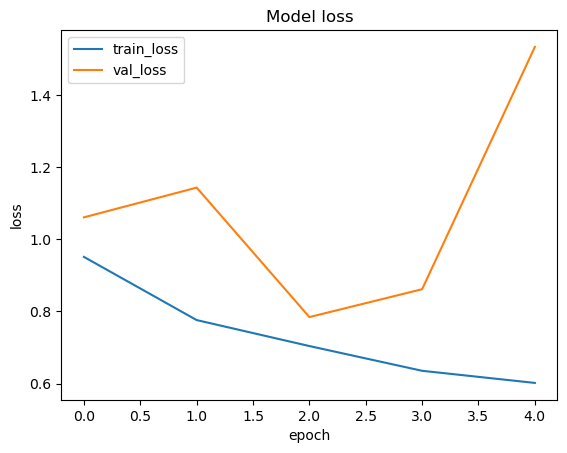

In [22]:

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train_loss', 'val_loss'])
plt.show()

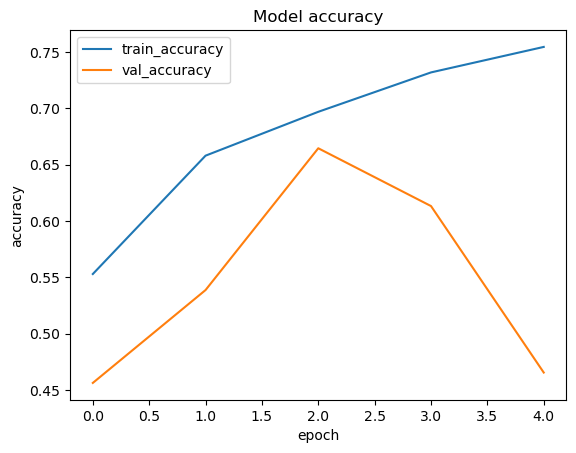

In [23]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [25]:

lenet_model.evaluate(validation_dataset)

72/72 [==============================] - 6s 76ms/step - loss: 1.5332 - accuracy: 0.4653 - top_k_accuracy: 0.7353


[1.5331659317016602, 0.4653204679489136, 0.7352941036224365]

# Testing

In [26]:
test_image = cv2.imread("Emotions Dataset/Emotions Dataset/test/sad/123731.jpg") 
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32) 
im = tf.expand_dims(im, axis = 0) 
print(lenet_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

tf.Tensor([[7.0836681e-01 8.1854741e-05 2.9155135e-01]], shape=(1, 3), dtype=float32)
angry


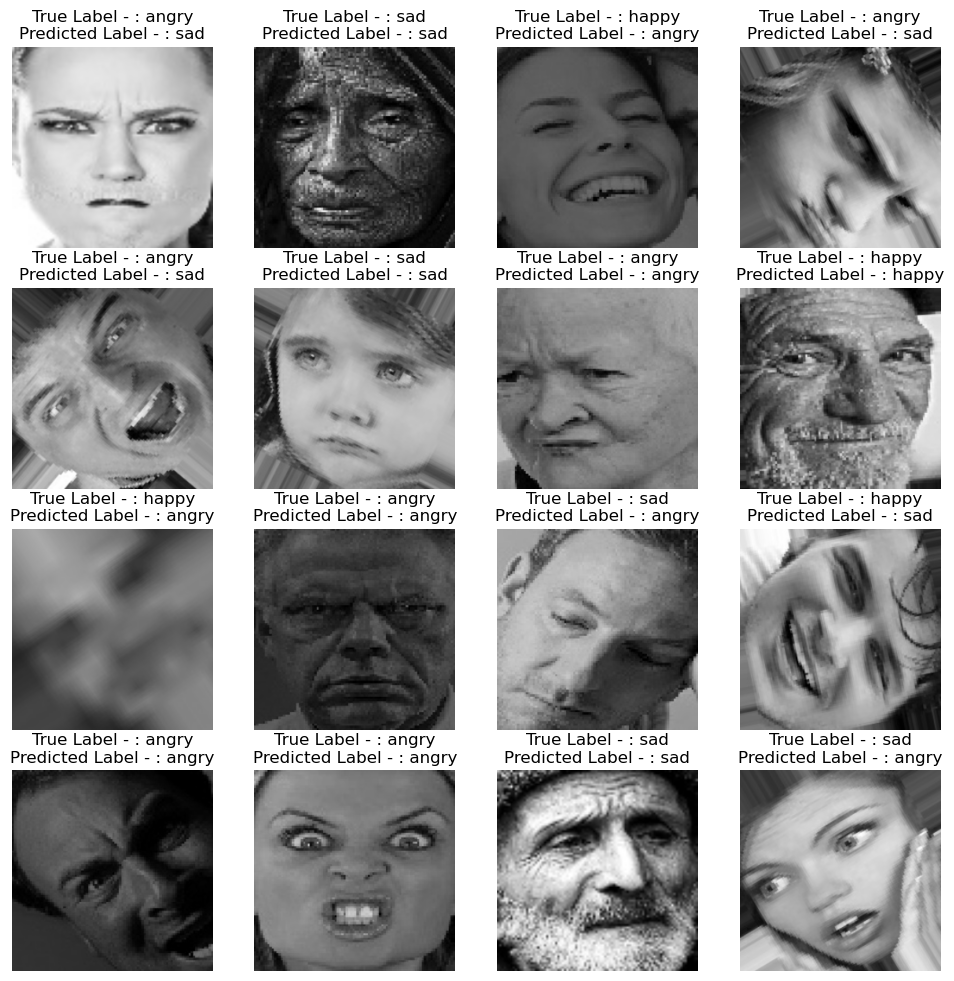

In [27]:

plt.figure(figsize = (12,12))
for images, labels in validation_dataset.take(1):
    for i in range(16): 
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] + "\n" + "Predicted Label - : " + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1)  .numpy()[0])] ) 
        plt.axis("off")

# Confusion Matrix

In [28]:
predicted = [] 
labels = [] 
for im, label in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [29]:

print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])) 
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 0 2 ... 1 2 0]
[2 0 0 ... 2 0 0]


In [30]:

pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]) 
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[359  34 122]
 [321 288 397]
 [301  43 413]]


Text(0.5, 58.7222222222222, 'Predicted')

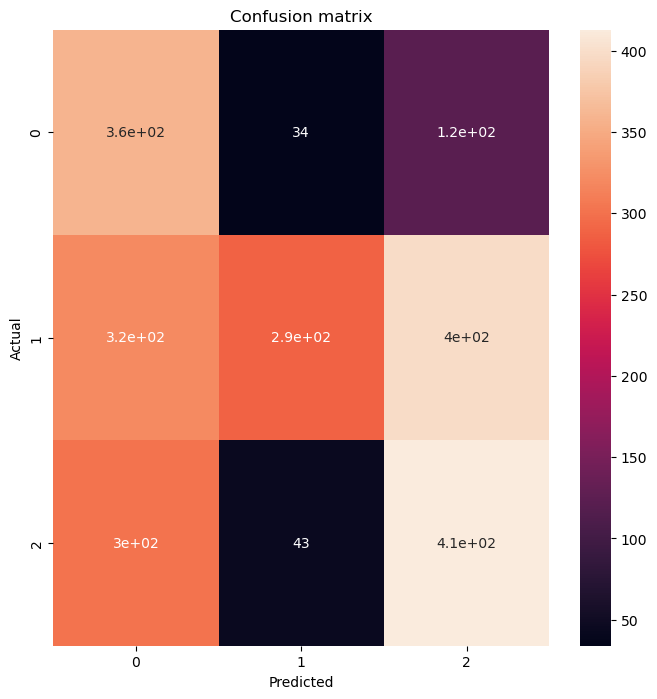

In [31]:

cm = confusion_matrix(lab, pred) 
print(cm) 
plt.figure(figsize=(8,8)) 
sns.heatmap(cm, annot=True,) 
plt.title('Confusion matrix')
plt.ylabel('Actual') 
plt.xlabel('Predicted')

# TFRecords

In [16]:
train_dataset = ( training_dataset .unbatch() )

val_dataset = ( validation_dataset  .unbatch()  )


In [17]:

def create_example(image, label): 
    bytes_feature = Feature( bytes_list=BytesList(value=[image])) 
    int_feature = Feature( int64_list=Int64List(value=[label])) 
    example = Example( features=Features(feature={ 'images': bytes_feature, 'labels': int_feature, })) 
    return example.SerializeToString()

In [18]:

NUM_SHARDS = 10 
PATH = 'tfrecords/shard_{:02d}.tfrecord'

def encode_image(image, label): 
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8) 
    image = tf.io.encode_jpeg(image)
    return image,tf.argmax(label)
encoded_dataset = ( train_dataset .map(encode_image) )

In [19]:
for shard_number in range(NUM_SHARDS): 
    sharded_dataset = ( encoded_dataset .shard(NUM_SHARDS, shard_number) .as_numpy_iterator() )
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for encoded_image, encoded_label in sharded_dataset:
            example = create_example(encoded_image, encoded_label)
            file_writer.write(example)

In [20]:

def parse_tfrecords(example):
    
    feature_description = {
        "images": tf.io.FixedLenFeature([], tf.string),
        "labels": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(example["images"], channels=3),
        dtype=tf.float32)
    return example["images"], example["labels"]

# Preparing the dataset for training
recons_dataset = tf.data.TFRecordDataset(
    filenames=[PATH.format(p) for p in range(NUM_SHARDS-2)]
)

# Parsing the dataset
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)




# Feature Map Visualization

In [21]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    
)

In [22]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [24]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input, 
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [26]:
test_image = cv2.imread("Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)
for i in range(len(f_maps)):
  print(f_maps[i].shape)

1/1 [==============================] - 1s 562ms/step
(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


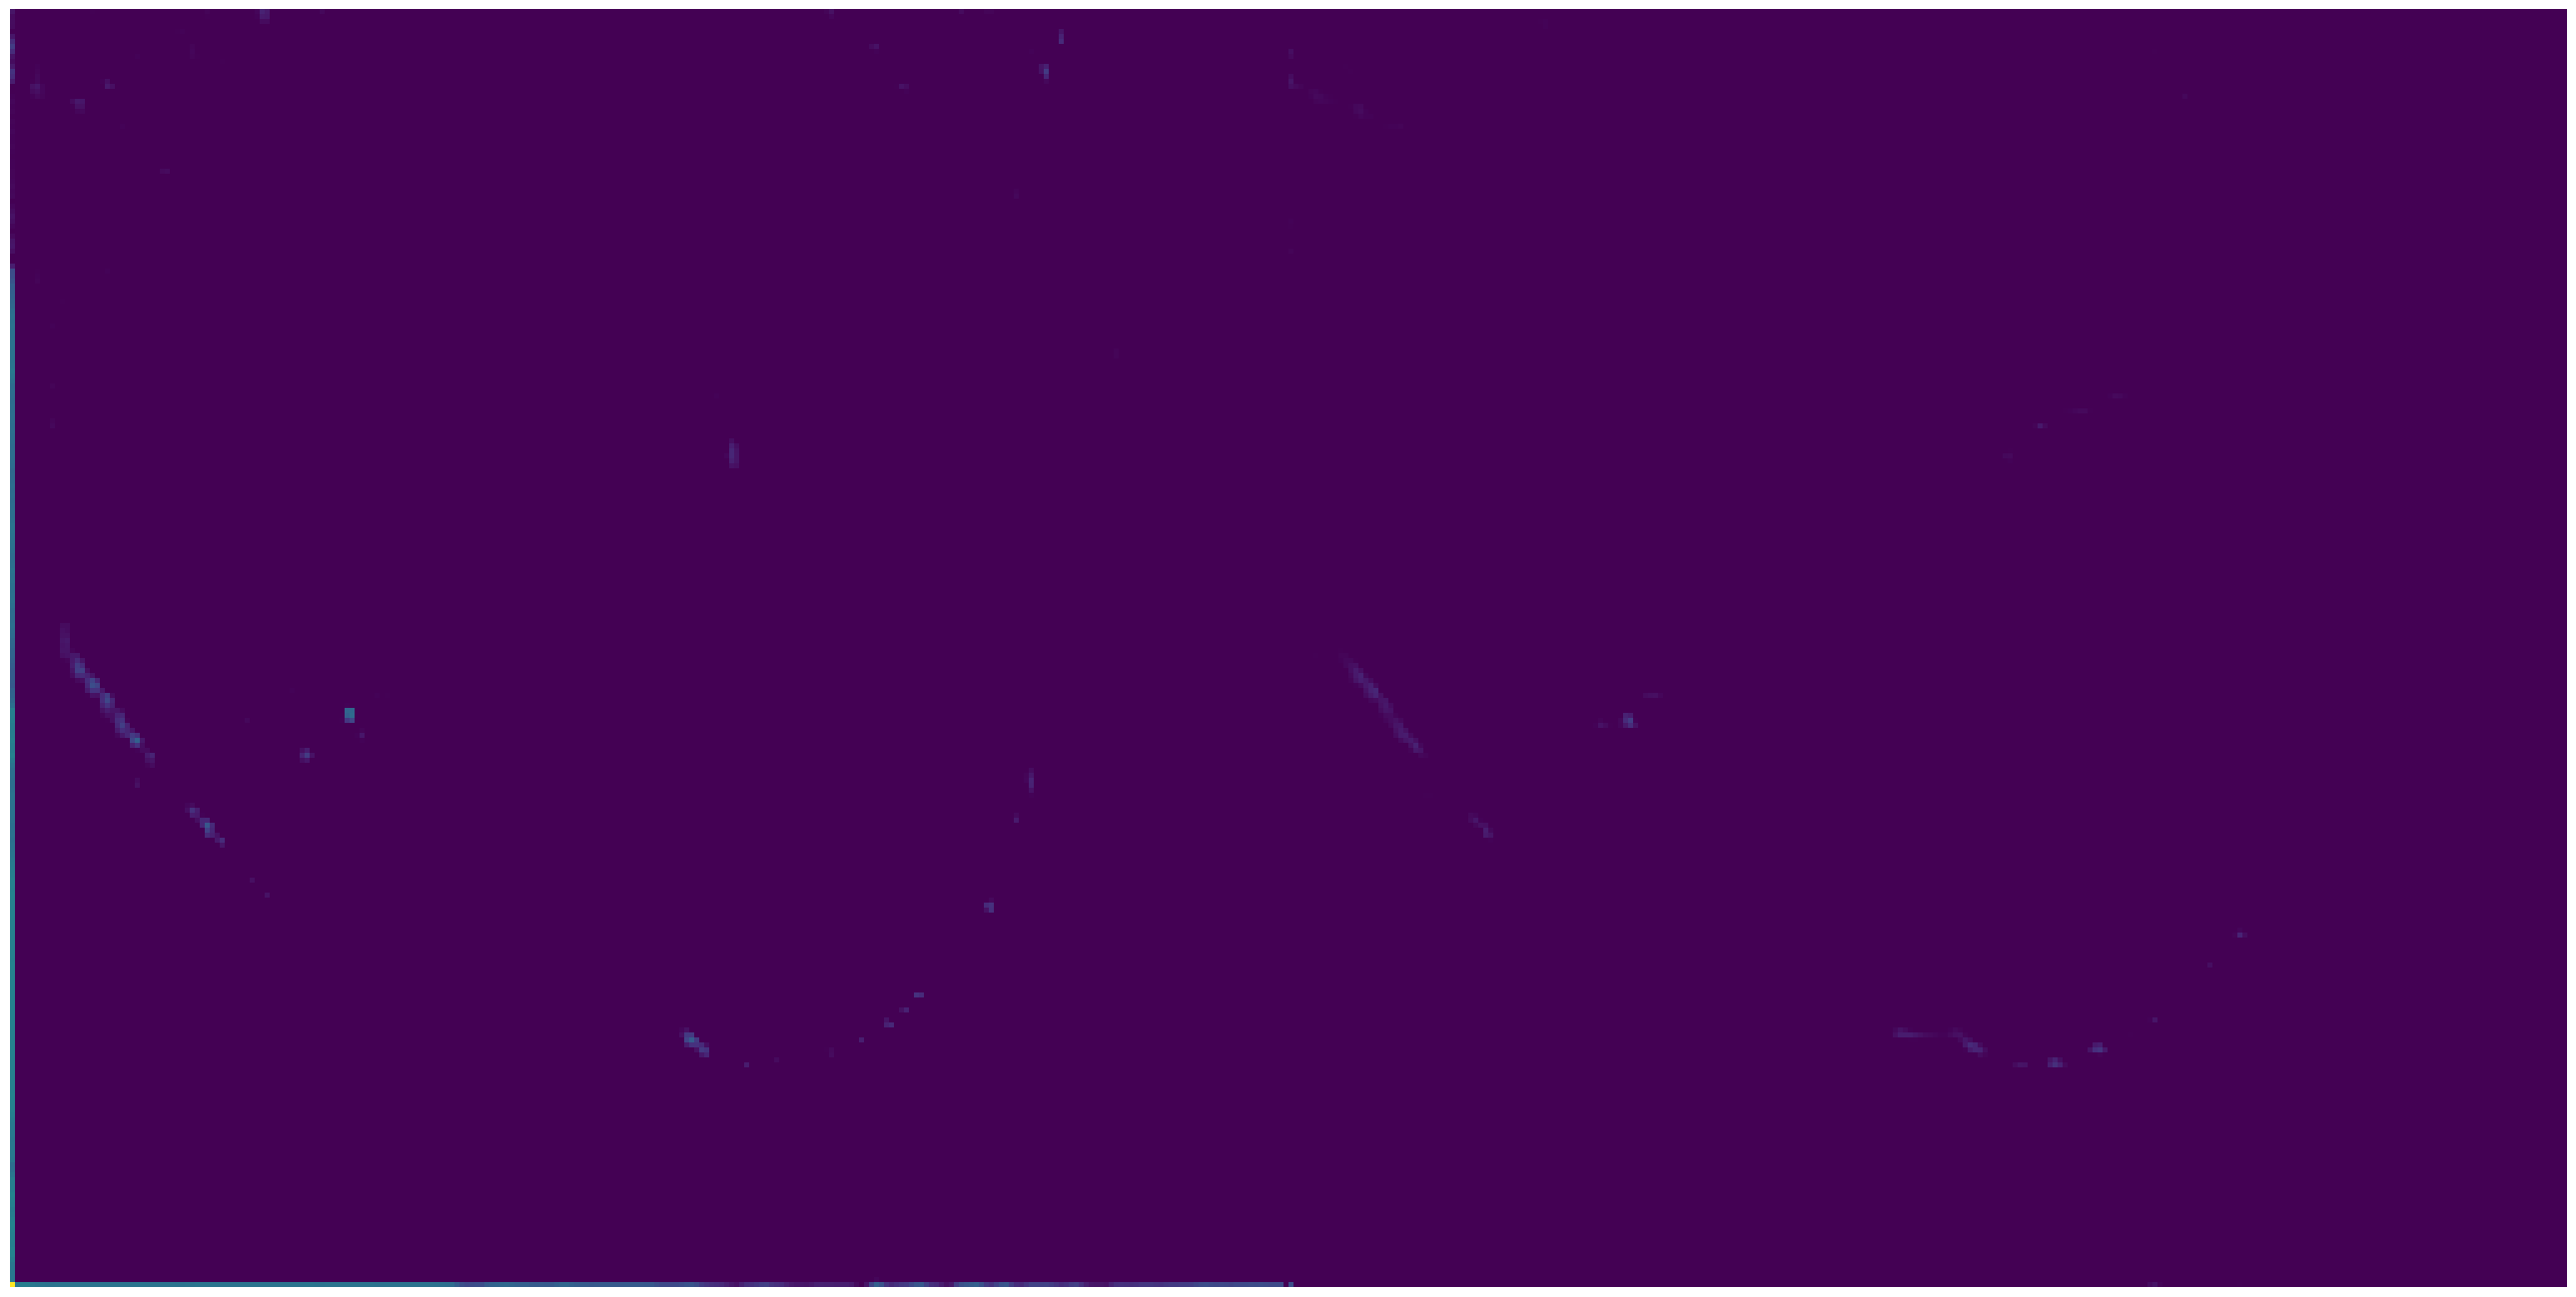

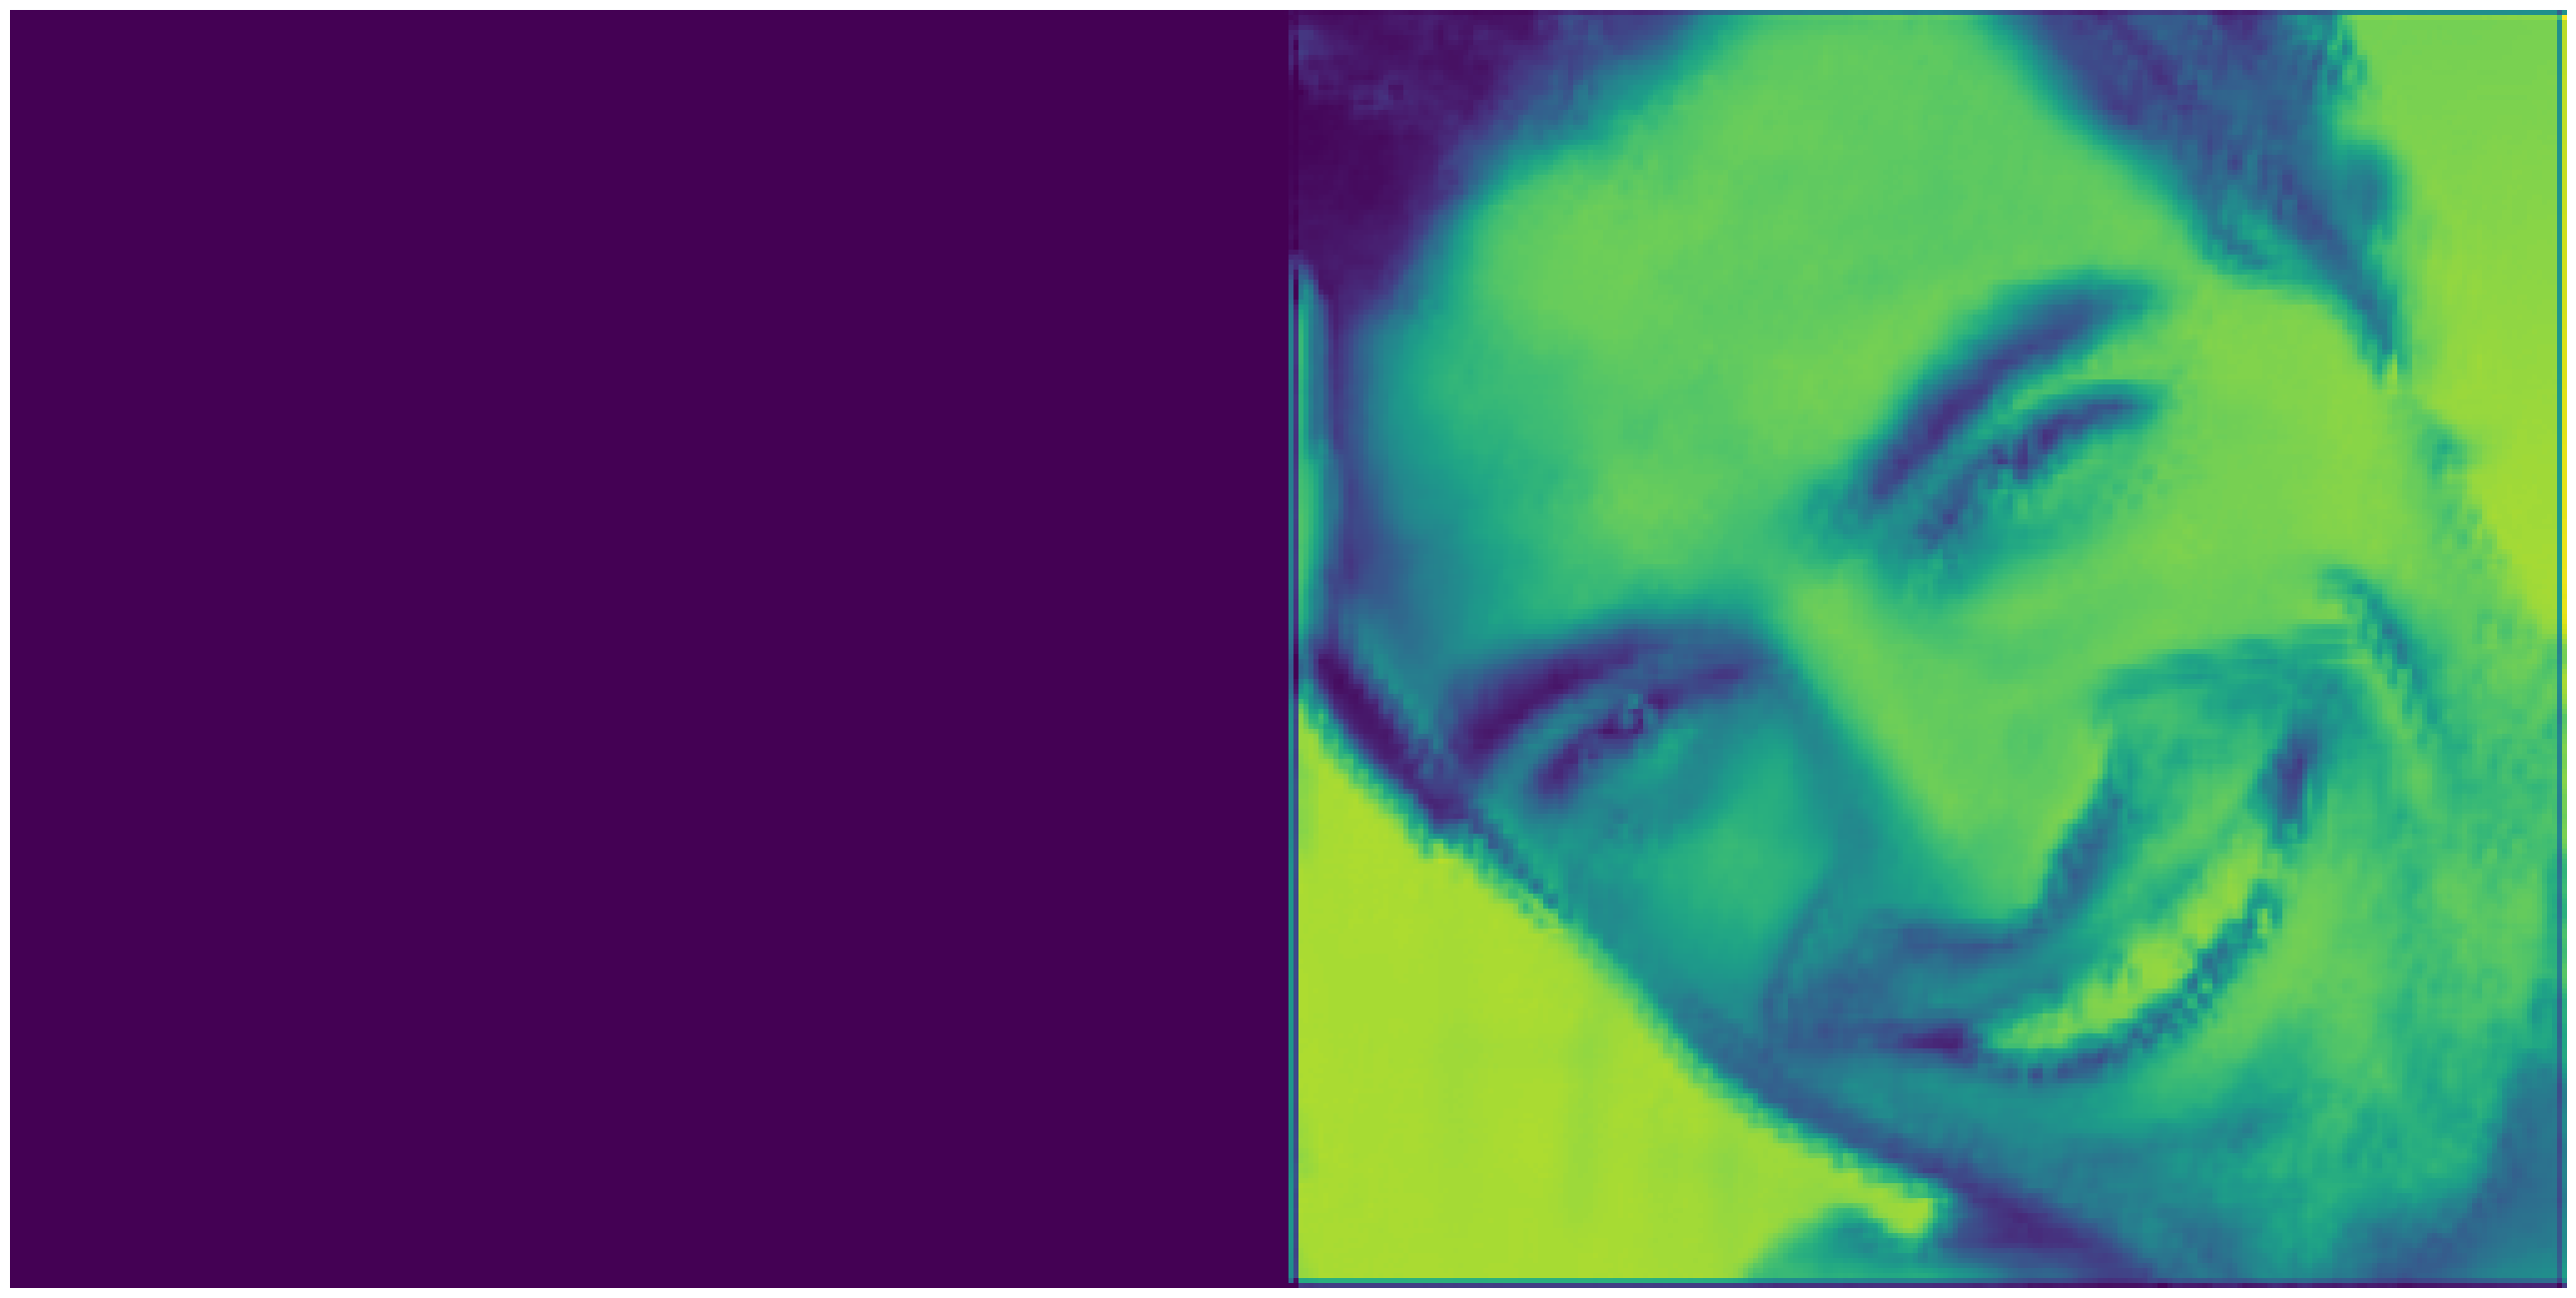

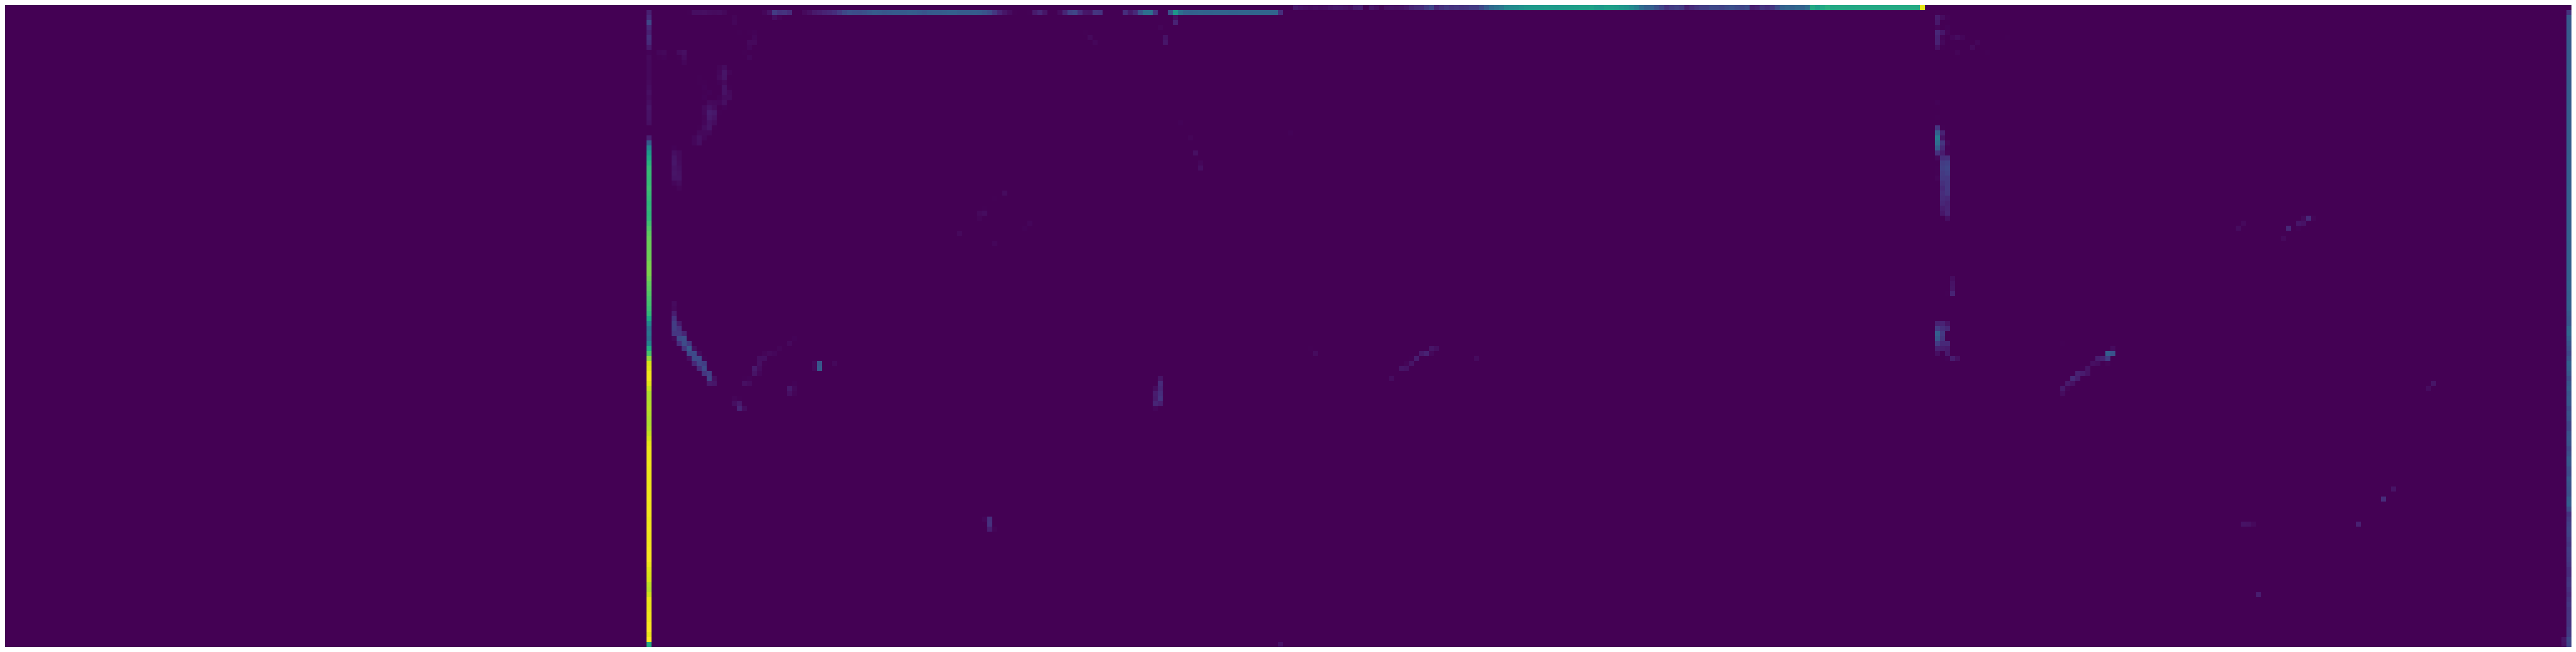

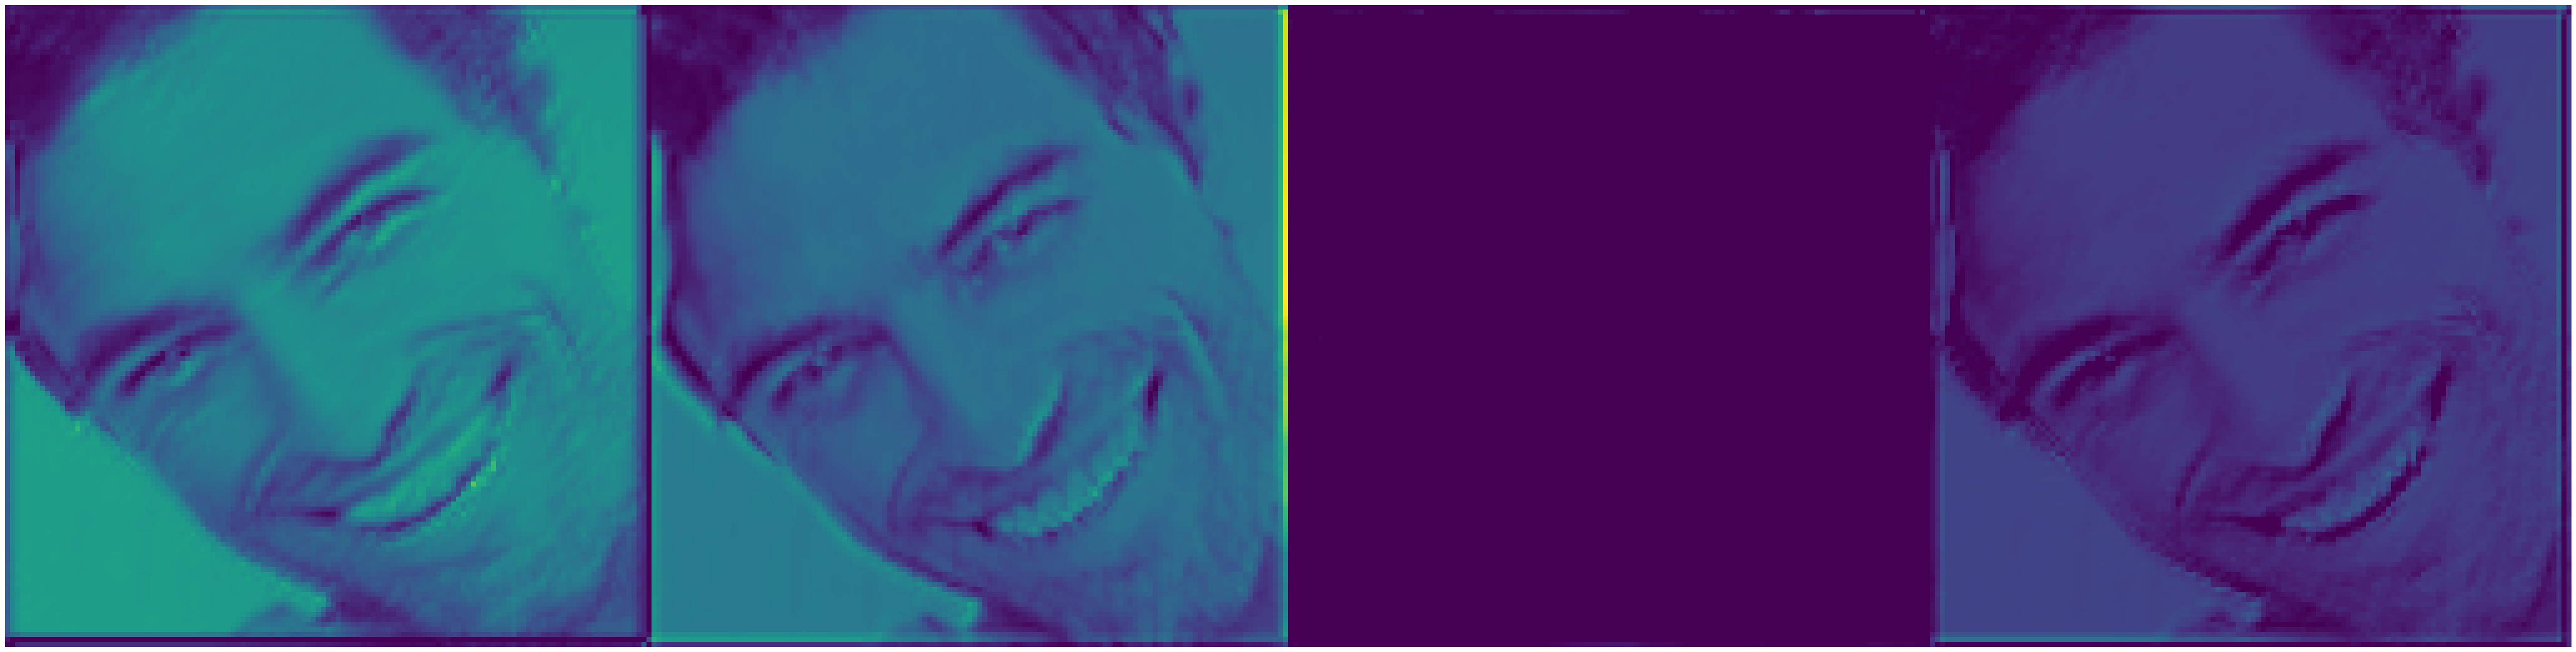

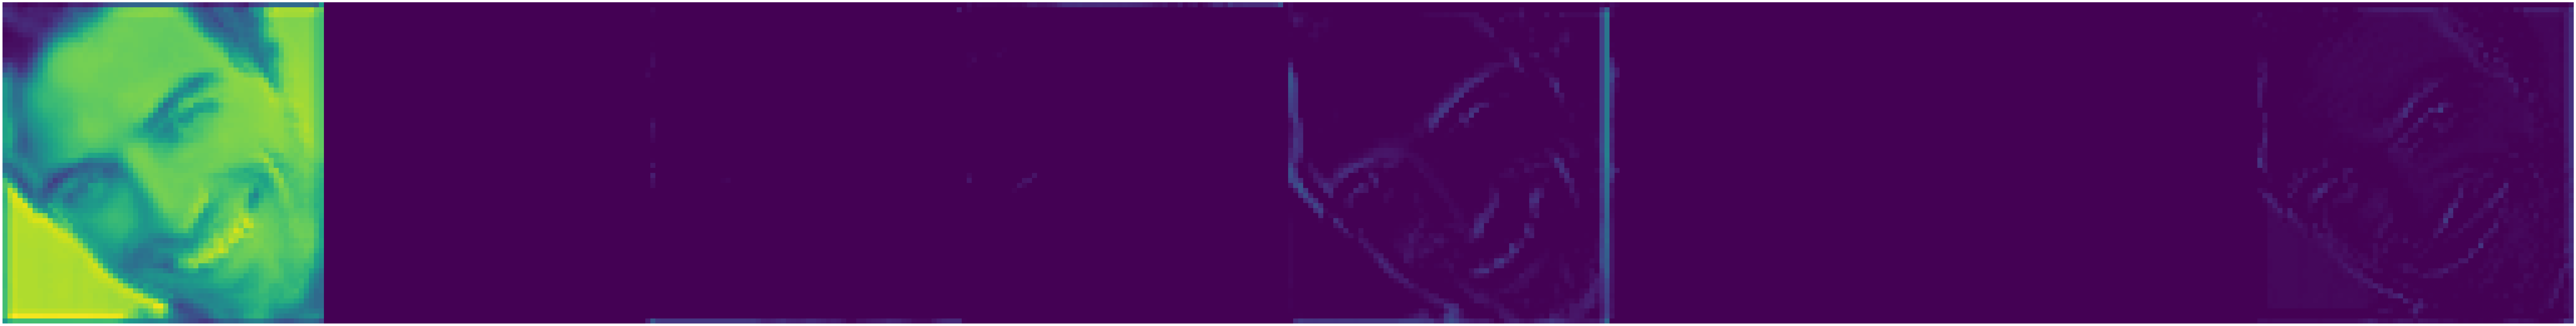

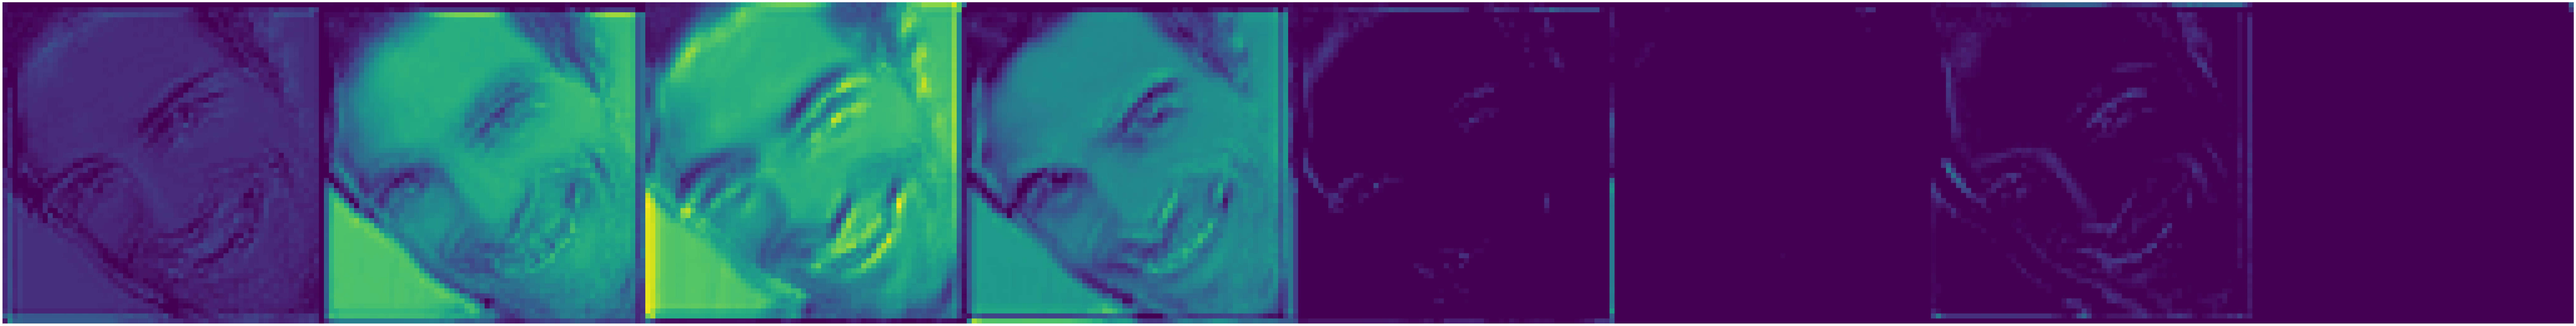

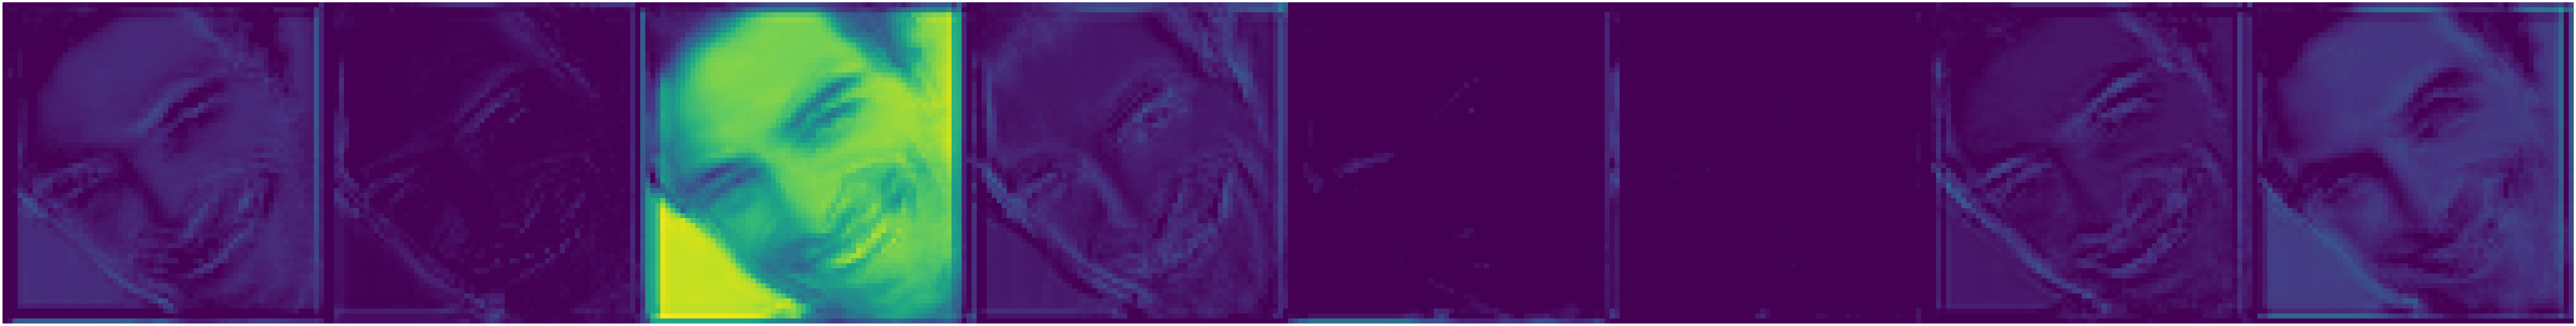

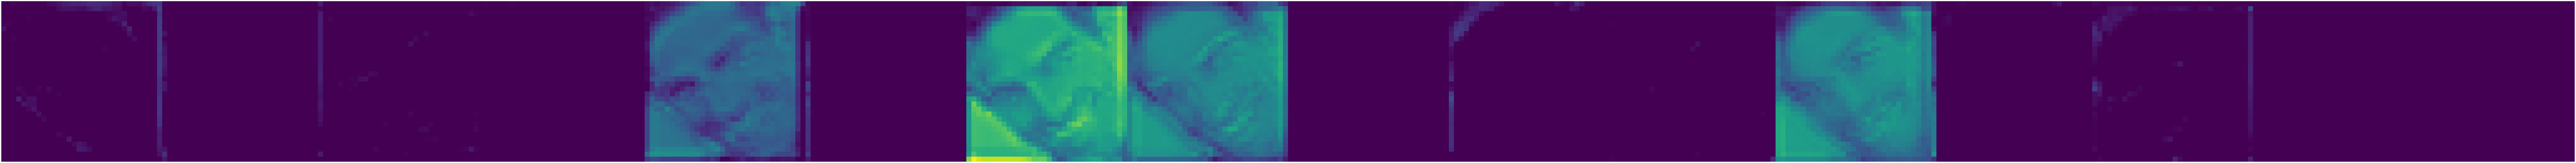

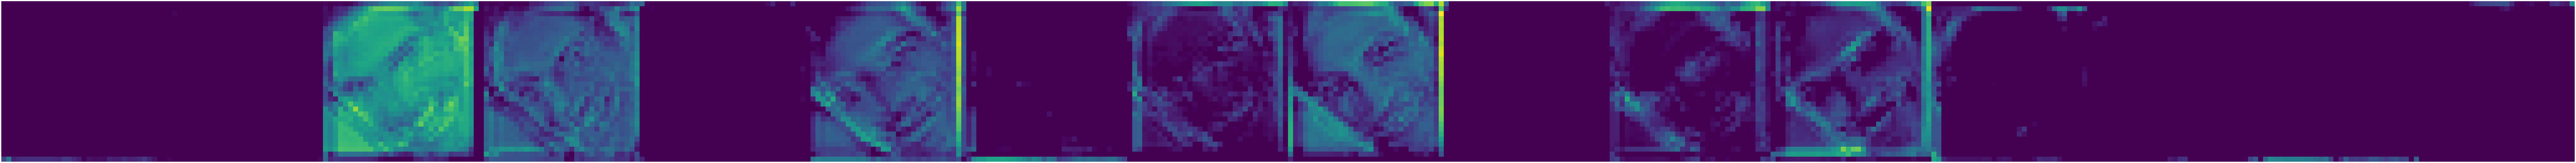

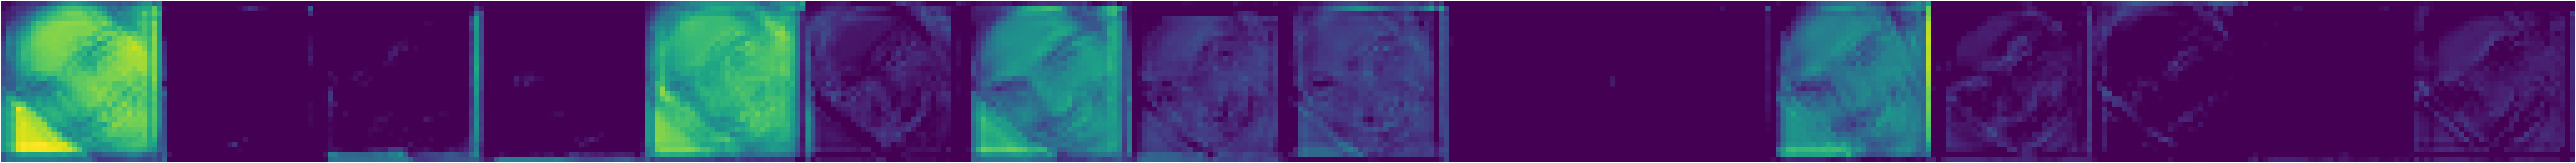

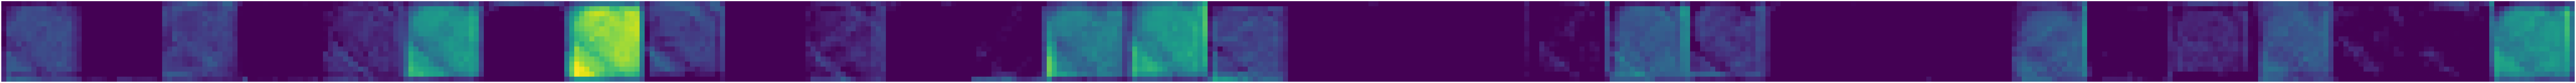

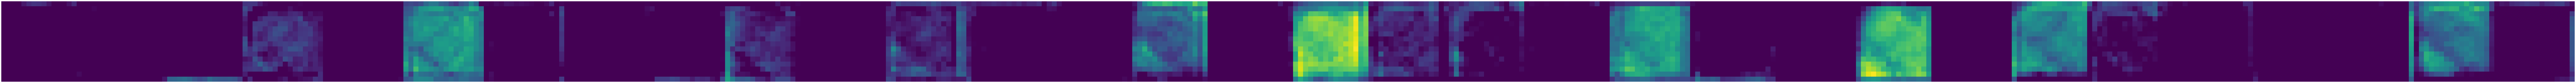

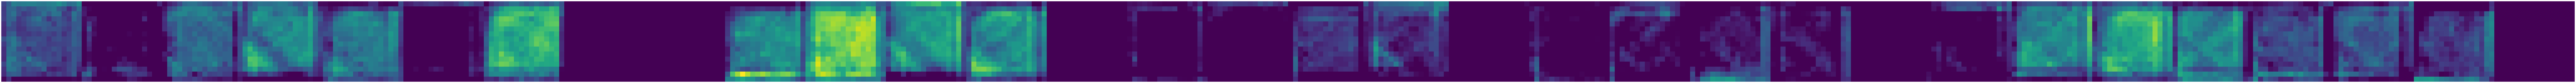

In [27]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)
  
  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")

# GradCam

In [28]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 164s 1us/step


In [29]:

x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]'] 

In [ ]:

pretrained_model.load_weights('Bang/mobilenet_human_emotions.h5')

In [30]:
img_path = "Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [31]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

(1, 256, 256, 3)


In [32]:
preds = pretrained_model.predict(img_array)

1/1 [==============================] - 7s 7s/step


In [33]:
print(preds)



[[0.2091913  0.47473827 0.31607038]]


In [36]:

last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [37]:
np.argmax(preds[0])

1

In [38]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [39]:

classifier_input = Input(shape=(8,8,2048))
x = classifier_input 
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [40]:

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(1, shape=(), dtype=int64)


In [41]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [42]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [43]:
print(pooled_grads.shape)

(2048,)


In [44]:

last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [45]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


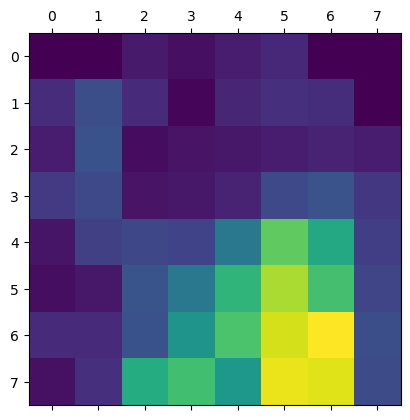

In [46]:

heatmap = np.sum(last_conv_layer_output, axis=-1)
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)


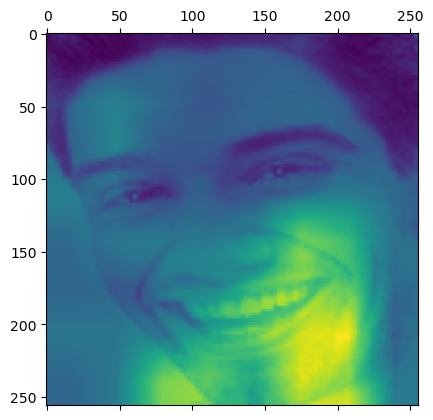

In [47]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)


HuggingFace ViT

In [18]:


!pip install transformers

In [19]:


resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))                
])

In [20]:


from transformers import ViTFeatureExtractor, TFViTModel

In [21]:

from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

C:\Users\fnaic\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fnaic\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [24]:

test_image = cv2.imread("Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))


In [25]:

hf_model(tf.expand_dims(test_image, axis = 0))

hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPo   86389248  
                             oling(last_hidden_state             
                             =(None, 197, 768),                  
                              pooler_output=(None, 7             
                             68),                                
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0     

In [26]:


from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [27]:

hf_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [30]:


history = hf_model.fit(
  training_dataset.take(20),
  validation_data = validation_dataset,
  epochs = 3,#CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/3
20/20 [==============================] - ETA: 0s - loss: 1.0900 - accuracy: 0.4266 - top_k_accuracy: 0.7312 

C:\Users\fnaic\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\fnaic\wandb\run-20240216_165857-pmo80cpn\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\fnaic\wandb\run-20240216_165857-pmo80cpn\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\fnaic\wandb\run-20240216_165857-pmo80cpn\files\model-best)... Done. 2.8s


ValueError: Too many dimensions: 4 > 3.

In [29]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
    
    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])
        
    wandb.log({"conf_mat": cm})
    
    

class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    
    columns=["image", "Predicted", "Label"]
    
    val_table = wandb.Table(columns = columns)

    
    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]
      
      val_table.add_data(*row)

      
    wandb.log({"Model Results" : val_table})